# Tutorial \#1: Integrating Geo2SigMap with Sionna RT - Coverage Map

This notebook provides an example of using Sionna RT to generate the coverage map for the target area, generated using Geo2SigMap's scene generation framework. This example contains five modules:

1. **Load and Preview** the generated scene for the target area;
2. **Configure** the transmitters (TXs) and receivers (RXs);
3. **Generate** the coverage map (or path gain map);
4. **Visualize** the results using Sionna's built-in functions;
5. **Plot/Save** the raw coverage map for further processing and analysis.

Please make sure that you have properly installed Sionna, e.g., via
```console
python3 -m pip install sionna
```

**Note: Starting from Sionna v1.0, the `CoverageMap` class has been replaced with the `RadioMap` class.**

In [1]:
# Core imports
import numpy as np
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt
import sionna
from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh, watt_to_dbm, transform_mesh,\
                      cpx_abs_square

## 1. **Load** and **Preview** the generated scene for the target area

We assume you have prepared the 3D scene XML file corresponding to the target area generated with our CLI tool `scenegen`, check `README.md` for details. 

You can use the following controls to preview the rendered 3D scene:
* Mouse left: Rotate
* Scroll wheel: Zoom
* Mouse right: Move

In [2]:
# Replace '../scenes/Boston/scene.xml' with the path to your scene file
SCENE_FOLDER = "../scenes/Boston"
scene = load_scene(f"{SCENE_FOLDER}/scene.xml")

# Interactive 3D visualization and view of the scene
scene.preview();

2025-06-24 07:29:55 WARN wrk20 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

## 2. **Configure** the transmitters and receivers

Next, we specify:
- The **transmit (TX)** antenna array is a planar array with a single element and isotropic pattern;
- The **receive (RX)** antenna array is a planar array with a single element but with a dipole pattern.

Then, we create a `Transmitter` object with a specific position and orientation, and add it to the `scene`.

**Note: Scene geographical coordinate system**
- Coordinate system: The center of the scene is at (0,0,0), the z-axis for the flat ground polygon is 0.
- Unit: Meters (m).

**Note: Sionna Azimuth/Elevation Format**
- Sionna defines the **antenna azimuth** in the range [-π, π) [rad]. The following code converts the commonly used **north-origin, clockwise-degree azimuth** to the format suitable for Sionna. Check the code below for details.

In [3]:
# Transmit array (single iso element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="cross"
)

# Create a single transmitter (tx0)
# - Positioned at x=0, y=0, z=100, in the unit of meters
# - Orientation toward 210 degree
tx0 = Transmitter(
    name="tx",
    position=[0, 0, 100],
    orientation=[-1 * (210 - 90) / 180 * np.pi, 0, 0]
)

# Add the transmitter instance to the scene
scene.add(tx0)

# Set the operating frequency in Hz (here, 3.65 GHz corresponds to the CBRS band)
scene.frequency = 3.65e9

## 3. **Generate** the coverage map (or path gain map)

The `RadioMap` method creates a **grid** of RX locations and performs ray tracing to calculate path gain between the TX and each grid point. In this example, we set:

- `max_depth=5` sets the maximum number of reflections/refractions to be 5;
- `los=True` enables the LOS paths;
- `cell_size=(2., 2.)` for a grid resolution of 2×2 meter, i.e., one pixel corresponds to an area of 2m x 2m;
- `size=[512, 512]` specifies that the radio map covers an area of 512m × 512m, and he corresponding radio map "image" has a dimension of 256x256.
- `samples_per_tx=int(1e8)` specifies the number of samples per source.

In [4]:
rm_solver = RadioMapSolver()


# Create a measurement surface by cloning the terrain
# and elevating it by 1.5 meters
measurement_surface = scene.objects["ground"].clone(as_mesh=True)
transform_mesh(measurement_surface,
            translation=[0,0,1.5])

rm = rm_solver(scene,
    max_depth=5,
    los=True,
    refraction=False,
    cell_size=(2., 2.),
    size=[512, 512],          # Size of the radio map in meters. The number of cells in the x and y directions should be [size/cell_size]
    # orientation=[0, 0, 0],    # Orientation of the radio map plane
    measurement_surface=measurement_surface, # TO BE UDPATED
    # center=[0, 0, 1.5],       # Center of the radio map measurement plane
    precoding_vec=None,
    samples_per_tx=int(1e8)
)

## 4. **Visualize** the results using Sionna's built-in functions

Sionna supports overlaying the radio map on top of the target scene. This allows for visual verification of how the path gain results align with the 3D world model. 


In [5]:
scene.preview(radio_map=rm, rm_db_scale=True, rm_metric="path_gain");

In [6]:
import numpy as np

def average_signal_grid_centered(centers, signal_strengths, grid_shape, cell_resolution):
    """
    Bin signal strengths by 2D grid centered at origin, skipping NaN values.

    Args:
        centers (np.ndarray): (N, 2) array of (x, y) centers (center-origin coordinates).
        signal_strengths (np.ndarray): (N,) signal values.
        grid_shape (tuple): (num_rows, num_cols) of output grid.
        cell_resolution (float or tuple): Size of cell in x and y, e.g., 1.0 or (x_res, y_res).

    Returns:
        np.ndarray: (num_rows, num_cols) array of average signal strengths.
    """
    if isinstance(cell_resolution, (float, int)):
        cell_resolution = (cell_resolution, cell_resolution)
    x_res, y_res = cell_resolution

    num_rows, num_cols = grid_shape

    Lx = num_cols * x_res
    Ly = num_rows * y_res
    x_min = -Lx / 2
    y_min = -Ly / 2

    x_idx = ((centers[:, 0] - x_min) / x_res).astype(int)
    y_idx = ((centers[:, 1] - y_min) / y_res).astype(int)

    x_idx = np.clip(x_idx, 0, num_cols-1)
    y_idx = np.clip(y_idx, 0, num_rows-1)

    sum_grid = np.zeros((num_rows, num_cols), dtype=np.float64)
    count_grid = np.zeros((num_rows, num_cols), dtype=np.int32)

    for xi, yi, sig in zip(x_idx, y_idx, signal_strengths):
        if not np.isnan(sig):
            sum_grid[yi, xi] += sig
            count_grid[yi, xi] += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        avg_grid = np.divide(sum_grid, count_grid, where=count_grid > 0)
        avg_grid[count_grid == 0] = np.nan

    return avg_grid


In [7]:
%%time

import numpy as np
from shapely.geometry import Polygon, box
from tqdm import tqdm
import argparse
import os
import trimesh

PLY_FILE = f"{SCENE_FOLDER}/mesh/lidar_terrain.ply"
mesh = trimesh.load(PLY_FILE)
triangle_colors = np.asarray(rm.path_gain).squeeze()

padding = 0
cell_size = 1.0

# --------------------------------------------------
# Project triangles to 2D (XY plane)
# 
#  In the context of orthographic projection, the 2D 
#  intersection between the triangle's projection and
#  the grid cell is the correct approach.
# --------------------------------------------------

triangle_polygons = []
for face in tqdm(mesh.faces):
    tri_3d = mesh.vertices[face]
    
    # Drop Z, only for orthographic projection 
    tri_2d = [(x, y) for x, y, z in tri_3d]  
    poly = Polygon(tri_2d)

    # Trim the illegal triangles
    if poly.is_valid and poly.area > 0:
        triangle_polygons.append(poly)
    else:
        # Keep the index valid
        triangle_polygons.append(None)
    

# --------------------------------------------------
# Define 2D flat grid
# --------------------------------------------------



# Get grid bounding box from mesh bounds
min_x, min_y = mesh.bounds[0][:2] - padding
max_x, max_y = mesh.bounds[1][:2] + padding
x_coords = np.arange(min_x, max_x, cell_size)
y_coords = np.arange(min_y, max_y, cell_size)

grid_w, grid_h = len(x_coords), len(y_coords)

# Output grid (RGB image and weight map)
color_grid = np.zeros((grid_h, grid_w))
weight_grid = np.zeros((grid_h, grid_w))

# --------------------------------------------------
# Area-weighted accumulation of triangle colors
# --------------------------------------------------
for i, tri in tqdm(enumerate(triangle_polygons), total=len(triangle_polygons)):
    if tri is None:
        continue
    tri_color = triangle_colors[i]

    # Skip the triangle with linear path gain value equals 0 will cause differnt result
    # Considering the  case that:
    # A cell covered by 2 triangles, each overlap area and path gain as follow:
    # Name     Path Gain value (linear)  Overlap Area Size
    # Tri_1            0                        0.5
    # Tri_2            0.2453                   0.2
    # 
    # The final results consideirng the zero gain triangle: (0*0.5 + 0.2435*0.2)/(0.5+0.2) = 0.069
    # The final results skip the zero gain triangle:        (0.2435*0.2)/(0.2) = 0.2435

    # if tri_color == 0:
    #     continue

    
    tri_bounds = tri.bounds

    # Compute overlapping grid cell index ranges
    x_start = np.searchsorted(x_coords, tri_bounds[0], side='right') - 1
    x_end   = np.searchsorted(x_coords, tri_bounds[2], side='left')
    y_start = np.searchsorted(y_coords, tri_bounds[1], side='right') - 1
    y_end   = np.searchsorted(y_coords, tri_bounds[3], side='left')

    for xi in range(x_start, x_end):
        for yi in range(y_start, y_end):
            cell = box(
                x_coords[xi], y_coords[yi],
                x_coords[xi] + cell_size, y_coords[yi] + cell_size
            )
            if not tri.intersects(cell):
                continue
            area = tri.intersection(cell).area

            # Floating-point instability / division by tiny weight
            # If the overlap_area is very small (e.g., < 1e-6), it acts like a divide-by-zero, 
            #  inflating the result.
            if area > 1e-6:
                color_grid[yi, xi] += area * tri_color
                weight_grid[yi, xi] += area

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340814/340814 [02:53<00:00, 1958.93it/s]

CPU times: user 3min 11s, sys: 509 ms, total: 3min 11s
Wall time: 3min 3s


In [8]:
# --------------------------------------------------
# Normalize by total contribution
# --------------------------------------------------
def compute_final_weighted_res(color_grid ,weight_grid):
    nonzero = weight_grid > 0 # set threshold
    res = color_grid.copy()
    res[nonzero] /= weight_grid[nonzero]
    res[~nonzero] = np.nan  # or 0, or masked
    return res

/tmp/ipykernel_1840643/1180706159.py:6: RuntimeWarning: divide by zero encountered in log10
  db_res = 10 * np.log10(navie_res)


(900, 988)


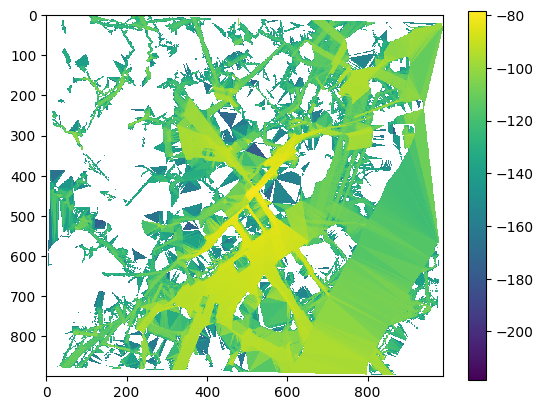

In [9]:
if isinstance(rm, sionna.rt.MeshRadioMap):
    # MeshRadioMap does not support the show() function.
    from matplotlib import pyplot as plt
    navie_res = compute_final_weighted_res(color_grid, weight_grid)
    print(navie_res[:,:].shape)
    db_res = 10 * np.log10(navie_res)
    plt.imshow(np.flip(db_res,0), interpolation="none")
    plt.colorbar()
else:
    # PlanarRadioMap
    rm.show(metric="path_gain");


## 5. **Plot** and **Save** the raw radio map

Here, we extract the raw `RadioMap` data from Sionna:
- Convert it to a `numpy` array;
- The radio maps can be stored and visualized in three forms: linear-scale, dB-scale, and a **flipped** version of the dB-scale.

**Note**: Sionna's indexing differs from the conventional coordinate origin assumptions, so flipping the map can help align with your expected orientation. The above function `rm.show()` achieves the same purpose as the `Radio Map (dB, flipped)` function. 

/tmp/ipykernel_1840643/3868585762.py:8: RuntimeWarning: divide by zero encountered in log10
  rm_npy_db = 10 * np.log10(rm_npy)
/tmp/ipykernel_1840643/3868585762.py:9: RuntimeWarning: divide by zero encountered in log10
  rm_npy_flipped_db = 10 * np.log10(np.flip(rm_npy, 0))


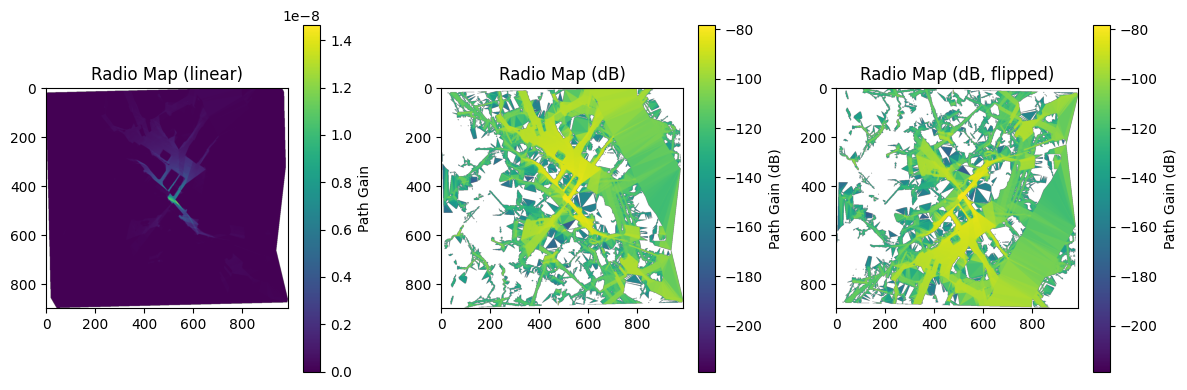

In [10]:
# Extract path gain from the coverage map with shape: (1, height, width)
if isinstance(rm, sionna.rt.MeshRadioMap):
    rm_npy = navie_res
else:
    rm_npy = rm.path_gain.numpy()[0, :, :]

# Convert path gain to dB scale, with flipping along axis 0
rm_npy_db = 10 * np.log10(rm_npy)
rm_npy_flipped_db = 10 * np.log10(np.flip(rm_npy, 0))

# Create side-by-side plots for radio maps in raw linear-scale, dB-scale, and flipped dB-scale
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Raw radio map (linear scale)
im_raw = axes[0].imshow(rm_npy)
axes[0].set_title('Radio Map (linear)')
cbar_raw = plt.colorbar(im_raw, ax=axes[0])
cbar_raw.set_label('Path Gain')

# 2) Coverage map in dB scale
im_db = axes[1].imshow(rm_npy_db)
axes[1].set_title('Radio Map (dB)')
cbar_db = plt.colorbar(im_db, ax=axes[1])
cbar_db.set_label('Path Gain (dB)')

# 3) Flipped coverage map in dB scale
im_db_flip = axes[2].imshow(rm_npy_flipped_db)
axes[2].set_title('Radio Map (dB, flipped)')
cbar_db_flip = plt.colorbar(im_db_flip, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB)')

plt.tight_layout()
plt.show()

**Closing Remark**:
Please refer to the [Sionna Documentation](https://nvlabs.github.io/sionna/) for more advanced features!